In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# LOAD DATASET

df= pd.read_csv("CustomerSegmentation15.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# REMOVE UNNECESSARY COLUMNS FOR RFM ANALYSIS
df= df[['InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'CustomerID']]
df.head()

,InvoiceNo,InvoiceDate,Quantity,UnitPrice,CustomerID
0,536365,12/1/2010 8:26,6,2.55,17850.0
1,536365,12/1/2010 8:26,6,3.39,17850.0
2,536365,12/1/2010 8:26,8,2.75,17850.0
3,536365,12/1/2010 8:26,6,3.39,17850.0
4,536365,12/1/2010 8:26,6,3.39,17850.0


In [13]:
# DATA CLEANING

df= df.dropna(subset= ['CustomerID'])   # Missing CustomerID
df= df[df['Quantity']>0]                # Negative or 0 quantity
df= df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Cancelled starting with 'C'

In [7]:
#CONVERT DATE COLUMN

df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [11]:
# CREATE TOTALAMOUNT COLUMN

df['TotalAmount']= df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,InvoiceDate,Quantity,UnitPrice,CustomerID,TotalAmount
0,536365,2010-12-01 08:26:00,6,2.55,17850.0,15.30
1,536365,2010-12-01 08:26:00,6,3.39,17850.0,20.34
2,536365,2010-12-01 08:26:00,8,2.75,17850.0,22.00
3,536365,2010-12-01 08:26:00,6,3.39,17850.0,20.34
4,536365,2010-12-01 08:26:00,6,3.39,17850.0,20.34


# RFM Part	           # Meaning	                       # Column Used
R – Recency	           How recently customer purchased	   InvoiceDate
F – Frequency	       How often customer purchased	       InvoiceNo
M – Monetary	       How much customer spent	           Quantity × UnitPrice
Customer identifier    Unique customer	                   CustomerID

In [15]:
# CALCULATE RFM VALUES

## 1. Set reference date

reference_date= df['InvoiceDate'].max()+pd.Timedelta(days=1)

In [17]:
## 2. Create RFM table

rfm= df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
})

rfm.columns= ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [19]:
## 3. RFM Scoring

rfm['R_score']= pd.qcut(rfm['Recency'],4, labels= [4,3,2,1])
rfm['F_score']= pd.qcut(rfm['Frequency'].rank(method='first'),4, labels= [1,2,3,4])
rfm['M_score']= pd.qcut(rfm['Monetary'],4, labels= [1,2,3,4])



In [20]:
## 4. Combine Scores

rfm['RFM_score']= (
    rfm['R_score'].astype(str)+
    rfm['F_score'].astype(str)+
    rfm['M_score'].astype(str)
)


In [23]:
## 5. Segment Customers

def segment_customer(row):
    if row['RFM_score']== '444':
        return "Champion"
    elif int(row['R_score'])>=3 and int(row['F_score'])>=3:
        return "Loyal"
    elif int(row['R_score'])<=2 and int(row['F_score'])>=3:
        return "At Risk"
    else:
        return "Regular"

rfm['segment']= rfm.apply(segment_customer, axis=1)


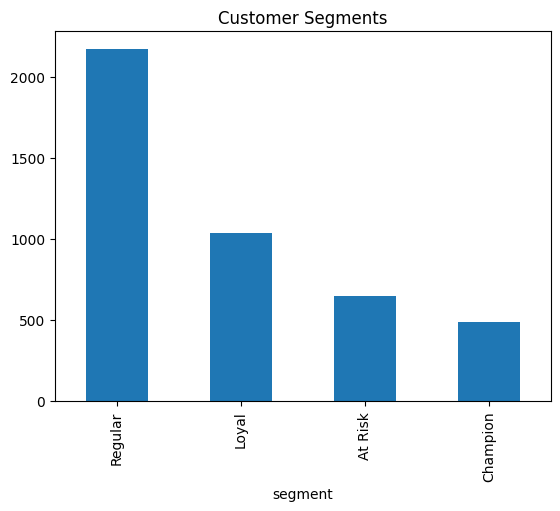

In [24]:
# VISUALIZATION
rfm['segment'].value_counts().plot(kind= 'bar')
plt.title("Customer Segments")
plt.show()

In [25]:
# EXPORT RESULT 

rfm.to_csv("rfm_segments.csv")